# Librerias

In [63]:
import pymssql        # Conexión a Azure para los datos
import pandas as pd
import numpy as np
import statistics
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

from pandas_profiling import ProfileReport
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())  # para usar la librería pandasql

from scipy.stats import skew, kurtosis
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
from sklearn.tree import export_text
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from schemdraw import flow #Diagramas Binary Tree

%matplotlib inline

In [32]:
!pip install schemdraw

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


# Datos

Nuestros  datos están en un servidor de Azure y en una DB de SQL Server, nos conectamos a ella por medio del siguiente código. Se puede notar que incluimos una de las limpiezas para que el dataset cargado ya la tuviera.


Se subieron los datos a Azure para que la misma data estuviera tanto en esta notebook como en Tableau.

In [22]:
conn = pymssql.connect(
     server="10khub-server.database.windows.net",
     port="---",
     user="---",
     password="---",
     database="---")

stroke_df = pd.read_sql("""
                         WITH cleanBMI AS ( 
                          SELECT bmi as clean FROM datahub
                         WHERE bmi <> 'N/A'                             
                         )
                         SELECT *, 
                         CASE 
                              WHEN bmi = 'N/A' THEN (SELECT AVG(CAST(clean AS float)) FROM cleanBMI)
                              ELSE bmi
                         END AS bmi_final
                         FROM datahub
                       """, conn)
conn.close()

In [64]:
LogReg_df = stroke_df.copy()

In [ ]:
from requests import get

ip = get('https://api.ipify.org').content.decode('utf8')
print('My public IP address is: {}'.format(ip))

My public IP address is: 34.227.206.217


# Etapa 1: Exploración

## Descripción de datos


### Diccionario
| Column            | Significado                                                                                                                                                                                                                                                                      |
|-------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| id                | Campo Único (5110 muestras) - Es decir tenemos 5110 personas                                                                                                                                                                                                                     |
| gender            | Campo Categórico de 3 Valores (Hombre/Mujer/Otro)<br>Hombre - 41.4% <br>Mujer  - 58.6%<br>Otro   -  0.0%                                                                                                                                                                         |
| age               | Campo Numérico que va desde 0 (se les considerará bebés, hay 43) hasta 82 años<br>La edad más común es 78 (2% de los datos)                                                                                                                                                      |
| hypertension      | Campo Categórico Binario <br>0 - No tiene Hipertensión (90.3% de las filas)<br>1 - Tiene Hipertensión (9.7 % de las filas)                                                                                                                                                       |
| heart_disease     | Campo Categórico Binario<br>0 - No tiene enfermedad del corazón (94.6% de las filas)<br>1 - Tiene enfermedad del corazón (5.4% de las filas)                                                                                                                                     |
| ever_married      | Campo Categórico <br>Yes - Estuvieron casados en algún momento (65.6%)<br>No  - No Estuvieron casados en algún moment (34.4%)                                                                                                                                                    |
| work_type         | Campo Categórico<br>Private<br>Self-Employed<br>Children - la persona es un niño<br>Govt_job<br>Never_Worked<br><br>Nota: La data no muestra a personas clasificadas como "Niño" arriba de 16 <br>y sí tienen arriba de 16, por lo general tienen un algo de las otras opciones. |
| Residence_type    | Campo Categórico dice en que tipo de lugar vien<br>Rural - 50.8% de las filas<br>Urban - 49.2% de las filas                                                                                                                                                                      |
| avg_glucose_level | Campo Numérico que dice el nivel promedio de glucosa en la persona<br>Tiene valores que van desde 55.12 a 271.74                                                                                                                                                                 |
| bmi               | Campo Númerico entre $[10.3,97.6]$ y una media $\mu$ de 28.89323691                                                                                                                                                                                                                                                                    |
| smoking_status    | Campo categórico con 4 posibles valores: nunca ha fumado, desconocido, ex-fumador y fumador.                                                                                                                                                                                                                                                                                  |
| stroke            | Variable booleana que indica si el paciente ha sufrido de un derrame cerebral, donde **0** es *"sin derrame"* y **1** *"ha sufrdio derrame"*                                                                                                                                                                                                                                                                                 |

In [ ]:
stroke_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,bmi_final
0,9046,Male,67,0,1,Yes,Private,Urban,228.690002,36.6,formerly smoked,1,36.600000
1,51676,Female,61,0,0,Yes,Self-employed,Rural,202.210007,N/A,never smoked,1,28.893237
2,31112,Male,80,0,1,Yes,Private,Rural,105.919998,32.5,never smoked,1,32.500000
3,60182,Female,49,0,0,Yes,Private,Urban,171.229996,34.4,smokes,1,34.400000
4,1665,Female,79,1,0,Yes,Self-employed,Rural,174.119995,24,never smoked,1,24.000000


In [ ]:
stroke_df.info() # Describiendo el tipo de datos.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   int64  
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                5110 non-null   object 
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
 12  bmi_final          5110 non-null   float64
dtypes: float64(2), int64(5), object(6)
memory usage: 519.1+ KB


In [ ]:
# Corregimos el tipo de datos de 'stroke' -> object.
stroke_df = stroke_df.astype({'stroke': object})

Escogimos estos datos primero por su aparente limpieza, segundo porque 800, 000 personas al año tienen un accidente cerebrovasculares y más de 140, 000  mueren y de los que sí sobreviven quedan con discapacidades. De acuerdo con cdc.gov, los accidentes son prevenibles. Lo que hizo que nos interesara el dataset para poner nuestro granito de arena en la prevención al decir si alguien puede o no tener un ataque cardiáco.

[Data dada por datathon - Click Aquí](https://docs.google.com/spreadsheets/d/1tjx0q4n3NANh04rfEtl0phkvDOscV1I51EcvZ9-cIG0/edit?usp=sharing)

[Dataset Explicado - Click Aquí](https://www.kaggle.com/fedesoriano/stroke-prediction-dataset)


CDCespanol. (2017, September 6). Prevención de muertes por accidentes cerebrovasculares. Centers for Disease Control and Prevention. https://www.cdc.gov/spanish/signosvitales/accidentes-cerebrovasculares/index.html

Cada fila es una persona dada la situación médica, se le nombrará paciente. Se mencionan datos demográficos y sobre su estado de salud tanto en variables categóricas como numericas. La columna "stroke" indica si la el paciente tuvu un accidente cerebrovascular

In [ ]:
profile = ProfileReport(stroke_df, title="Stroke EDA Report", explorative=True)
profile.to_file(output_file="Raw_StrokeData_Report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Para explorar un poco más rápido la data se utilizó la librería de Explorative Data Analysis que permite acelerar el entendimiento de las variables que se tienen en nuestro dataset. El reporte se encuentra en [Raw_StrokeData_Report.html](https://github.com/ArmandoDLaRosa/10k-Datathon/blob/main/Raw_StrokeData_Report.html), que es dentro de nuestro repo de github

In [ ]:
# En el Pandas profiling se encontró que se tenía id como campo único,
# pero queríamos ver que tantas filas únicas eran únicas, para considear
# a un id como una persona distinta.
strokeTmp = stroke_df
print("Cantidad Filas Totales ",stroke_df.shape[0], "\nCantidad Filas Únicas  ", strokeTmp.drop_duplicates().shape[0])

Cantidad Filas Totales  5110 
Cantidad Filas Únicas   5110


In [ ]:
# En el pandas profiling se encontraron datos aludiendo a personas de 0 años, 
# así que fuimos a investigar si eran una muestra representativa. Pero, solo
# se encontraron que eran un 0.84% del total de datos
query = """SELECT (count(*)*100/5110.0) as babies_Percent
       FROM stroke_df
       WHERE age < 1"""
display(pysqldf(query))

,babies_Percent
0,0.841487


In [ ]:
# Sale la duda de hasta que edad consideran que es un niño en el dataset
query1 = """   SELECT max(age) as Kids_MaxAge
              FROM stroke_df
              WHERE work_type = 'children'"""

query2 = """   SELECT age as YouthAge
              FROM stroke_df
              WHERE age > 10 and age < 21
              GROUP BY age """ 
                      
query3 = """  SELECT distinct age, work_type
              FROM stroke_df
              WHERE age > 16 and age < 21"""        

display(pysqldf(query1))
display(pysqldf(query2))
display(pysqldf(query3))



,Kids_MaxAge
0,16


,YouthAge
0,11
1,12
2,13
3,14
4,15
5,16
6,17
7,18
8,19
9,20


,age,work_type
0,20,Private
1,17,Self-employed
2,18,Private
3,17,Private
4,20,Govt_job
5,18,Self-employed
6,19,Private
7,19,Self-employed
8,19,Never_worked
9,17,Never_worked


## Objetivo

Lo que nos interesa es ver que variables generan un modelo que permita ver quien va a tener o no un ataque cerebral para poder ayudar en la detección previa de ataques cerebrales

## Selección

Los datos se guardaron en un servidor de azure protegido por IP, para facilitar el acceso a ellos. Pero, las transformaciones se hicieron en la misma libreta adecuándanos al modelo de Predicción. 

Se realizaron distintos modelos con las cuales se usaron distintas limpiezas como la creación de categorías de las variables de BMI, de Glucosa y Edad. 

Al dataset  original, del que se hicieron las adaptaciones por modelo, les limpiamos el BMI, porque había NANs en formato de texto, pero nosotros estabamos trabajando esa variable como continua. Los NANs los imputamos con el promedio de la columna, que era lo más adecuado desde que no estabamos trabajando con series de tiempo ni muchos datos.En algunos modelos pasamos las variables categóricas de texto a números identificadores de la categoría. Pero, en sí la data estaba limpia solo era cuestión de realizarle transformaciones.



## Exploración
Grafica variables vs otras. Dos graficas por integrante de equipo junto una explicación sobre las observaciones.

Usa Watson, Tableau, Power BI para explorar relaciones entre datos y reporta lo que encontraste.

[Text(0.5, 1.0, 'Strokes by Age '),
 Text(0.5, 0, 'Age'),
 Text(0, 0.5, 'Strok or Not Count')]

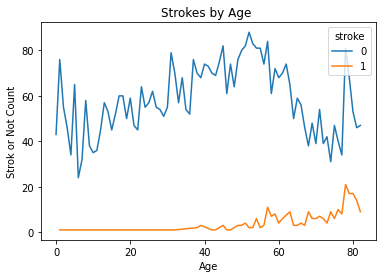

In [ ]:
query1 = """  SELECT age, stroke, count(stroke) as count
              FROM stroke_df
              GROUP BY age,stroke
              ORDER BY age"""        

age_stroke = pysqldf(query1)
sns.lineplot(data = age_stroke, x='age', y='count', hue='stroke').set(title='Strokes by Age', xlabel='Age', ylabel='Strok or Not Count')

In [ ]:
from IPython.display import IFrame
IFrame("Strokes_Tableau.pdf", width=600, height=300)  # Si no se observa buscarlo en el repo de github

# Etapa 2: Análisis estadístico

* Histograma
* Media
* Varianza
* Desviación estándar
* Simetría
* Curtosis 

Interpretación de los estadísticos descriptivos sobre dichas variables, ofrece una explicación sobre la varianza, media, desviación estandar.
Estas son hipotesis sobre los datos. Recuerda redactar esto precisamente como hipotesis, y basarte en los números que obtuviste en el análisis. Por ultimo, para cada una de las variables incluye también tu inferencia sobre que distribución de probabilidad y explica el comportamiento de la variable.

Basandonos en la forma del histograma, pesamos que esta variable podría tener una distribución nomal de la información y se encuentra cesgado hacia la derecha por lo que podriamos asumir que la variable tiene una mayor cantidad de información en este rango de numeros.

Podemos observar en la siguiente información que hay mucha variedad de edades con media de 43 años, varianza de 512 y desviación estandar de 22.6. El coeficiente de asimetría el negativo lo cual nos indica que las edades son mas predominantes debajo de la media y la curtosis es muy negativa lo cual indica que la curva no es muy uniforme.

Media: 43 
Varianza: 512.1916261043731 
Desviacion Estandar: 22.631650980526654 
Asimetria: -0.14038415612751481 
Curtosis: -0.9859237869334208


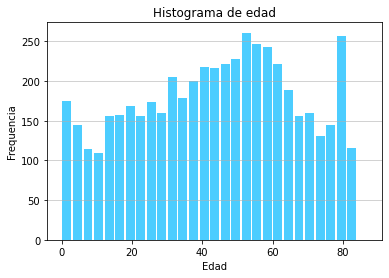

In [ ]:

edad = stroke_df['age'].to_numpy()
bins_edad =list(range(0, 90, 3))
n, bins, patches = plt.hist(x=edad, bins=bins_edad, color='#00b8ff',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.7)
plt.xlabel('Edad')
plt.ylabel('Frequencia')
plt.title('Histograma de edad')
#plt.text(10, 300, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
#plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
media_edad = statistics.mean(edad)
varianza_edad = np.var(edad)
desviacion_edad = np.std(edad)
asasimetria_edad = skew(edad)
curtosis_edad = kurtosis(edad)
print('Media: {} \nVarianza: {} \nDesviacion Estandar: {} \nAsimetria: {} \nCurtosis: {}' .format(media_edad, varianza_edad, desviacion_edad, asasimetria_edad, curtosis_edad) )
plt.show()

En cuanto la glucosa, la media del nivel de glucosa es de 106 mg/dl donde su varianza es muy alta teniendo valor de 2050.2 y una desviacion estandar de 45, una asimetria de 1.5 lo cual nos dice que los niveles de azucar son mas predominantes en la sección alta de la media y una curtosis similar de 1.6.

Media: 106.14767708078523 
Varianza: 2050.1995287902564 
Desviacion Estandar: 45.27912906395458 
Asimetria: 1.5718222978297214 
Curtosis: 1.677660756940603


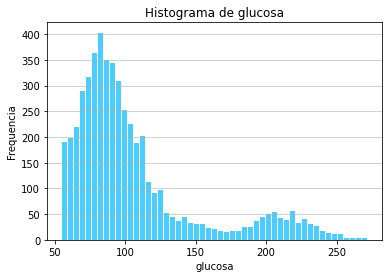

In [ ]:
glucosa = stroke_df['avg_glucose_level'].to_numpy()
n, bins, patches = plt.hist(x=glucosa, bins='auto', color='#00b8ff',
                            alpha=0.7, rwidth=0.8)
plt.grid(axis='y', alpha=0.7)
plt.xlabel('glucosa')
plt.ylabel('Frequencia')
plt.title('Histograma de glucosa')
#plt.text(10, 300, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
#plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
media_glucosa = statistics.mean(glucosa)
varianza_glucosa = np.var(glucosa)
desviacion_glucosa = np.std(glucosa)
asasimetria_glucosa = skew(glucosa)
curtosis_glucosa = kurtosis(glucosa)
print('Media: {} \nVarianza: {} \nDesviacion Estandar: {} \nAsimetria: {} \nCurtosis: {}' .format(media_glucosa, varianza_glucosa, desviacion_glucosa, asasimetria_glucosa, curtosis_glucosa) )

En el caso del indice de masa corporal (bmi) tiene un valor medio de 28.9 donde la varianza es moderada con 59.2 y una desviacion estadar de 7.7, una asimetria de casi 1 lo cual hace a los datos muy simetricos y curtosis de 3.6 lo que se nota en la parte grafica de la tabla la elevacion de la curva.

Media: 28.893236911794663 
Varianza: 59.247881695787 
Desviacion Estandar: 7.6972645592955296 
Asimetria: 1.0763999841401004 
Curtosis: 3.618343289491855


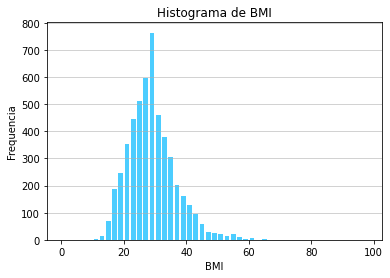

In [ ]:
bmi = stroke_df['bmi_final'].to_numpy()
binss =list(range(0, 100, 2))
n, bins, patches = plt.hist(x=bmi, bins=binss, color='#00b8ff',
                            alpha=0.7, rwidth=0.74)
plt.grid(axis='y', alpha=0.7)
plt.xlabel('BMI')
plt.ylabel('Frequencia')
plt.title('Histograma de BMI')
#plt.text(10, 300, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
#plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
media_bmi = statistics.mean(bmi)
varianza_bmi = np.var(bmi)
desviacion_bmi = np.std(bmi)
asasimetria_bmi = skew(bmi)
curtosis_bmi = kurtosis(bmi)
print('Media: {} \nVarianza: {} \nDesviacion Estandar: {} \nAsimetria: {} \nCurtosis: {}' .format(media_bmi, varianza_bmi, desviacion_bmi, asasimetria_bmi, curtosis_bmi) )

# Etapa 3: Modelación

### Modelos Aplicados
- PCAs - Principal Component Analysis
- K-Medias - Clustering
- Árboles de decisión - Classification
- Regresión logistica binaria - Classification

Se reporta la tecnica, el modelo, sus ajustes y los resultados.

### Analisis de Componentes Principales (PCA)

El analisis de componentes principales en este caso nos va a servir para visualizacion de nuestra base de datos, dando informacion adicional sobre ella y entender mejor las condiciones de nuestros datos. Empezamos por seleccionar las variables de edad, nivel de glucosa y bmi con el proposito de utilizarlas en el modelo PCA.

In [ ]:
PCA_df = stroke_df[['age', 'avg_glucose_level', 'bmi_final']].copy

Utilizando la funcion pipeline de sklearn para realizar diferentes operaciones en las columnas, es necesario normalizar los datos para este metodo, despues los importamos con el modelo PCA; los entrenamos con la funcion fit y extraemos el resultado.

In [ ]:
# Entrenamiento modelo PCA con escalado de los datos
# ==============================================================================
pca_pipe = make_pipeline(StandardScaler(), PCA())
pca_pipe.fit(PCA_df)

# Se extrae el modelo entrenado del pipeline
modelo_pca = pca_pipe.named_steps['pca']

In [ ]:
# Se combierte el array a dataframe para añadir nombres a los ejes.
pd.DataFrame(
    data    = modelo_pca.components_,
    columns = PCA_df.columns,
    index   = ['PC1', 'PC2', 'PC3']
)

,age,avg_glucose_level,bmi_final
PC1,0.631350,0.504771,0.588730
PC2,0.180214,-0.833878,0.521699
PC3,-0.754268,0.223278,0.617436


Creamos un heatmap para vizualizar las relaciones entre los componentes principales y nuestras variables

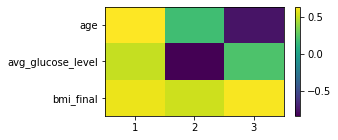

In [ ]:
# Heatmap componentes
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 2))
componentes = modelo_pca.components_
plt.imshow(componentes.T, cmap='viridis', aspect='auto')
plt.yticks(range(len(PCA_df.columns)), PCA_df.columns)
plt.xticks(range(len(PCA_df.columns)), np.arange(modelo_pca.n_components_) + 1)
plt.grid(False)
plt.colorbar();

----------------------------------------------------
Porcentaje de varianza explicada por cada componente
----------------------------------------------------
[0.49819232 0.28099187 0.22081581]


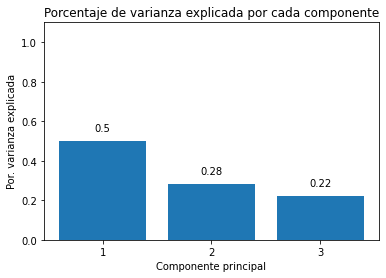

In [ ]:
# Porcentaje de varianza explicada por cada componente
# ==============================================================================
print('----------------------------------------------------')
print('Porcentaje de varianza explicada por cada componente')
print('----------------------------------------------------')
print(modelo_pca.explained_variance_ratio_)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.bar(
    x      = np.arange(modelo_pca.n_components_) + 1,
    height = modelo_pca.explained_variance_ratio_
)

for x, y in zip(np.arange(len(PCA_df.columns)) + 1, modelo_pca.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_ylim(0, 1.1)
ax.set_title('Porcentaje de varianza explicada por cada componente')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza explicada');

------------------------------------------
Porcentaje de varianza explicada acumulada
------------------------------------------
[0.49819232 0.77918419 1.        ]


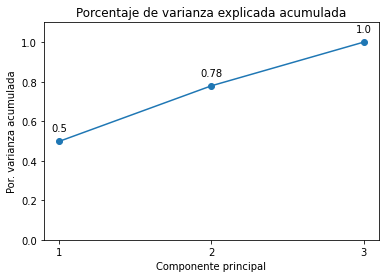

In [ ]:
# Porcentaje de varianza explicada acumulada
# ==============================================================================
prop_varianza_acum = modelo_pca.explained_variance_ratio_.cumsum()
print('------------------------------------------')
print('Porcentaje de varianza explicada acumulada')
print('------------------------------------------')
print(prop_varianza_acum)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.plot(
    np.arange(len(PCA_df.columns)) + 1,
    prop_varianza_acum,
    marker = 'o'
)

for x, y in zip(np.arange(len(PCA_df.columns)) + 1, prop_varianza_acum):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )
    
ax.set_ylim(0, 1.1)
ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_title('Porcentaje de varianza explicada acumulada')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza acumulada');

In [ ]:
features = ['age', 'avg_glucose_level', 'bmi_final']
x = stroke_df.loc[:, features].values

y = stroke_df.loc[:,['stroke']].values
x = StandardScaler().fit_transform(x)
pca = PCA(n_components=3)

In [ ]:
principalComponents = pca.fit_transform(x)

Obtenemos los valores propios de cada componente principal para observar la varianza explicada

In [ ]:
eigenvalues = pca.explained_variance_
eigenvalues

array([1.49486949, 0.84314061, 0.6625771 ])

In [ ]:
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3'])

In [ ]:
finalDf = pd.concat([principalDf, stroke_df[['stroke']]], axis = 1)

Realizamos un scatterplot visualizando los primeros dos componentes principales donde los puntos rosas son las personas que no tuvieron un ataque cerebrovascular y los puntos azules los que si.

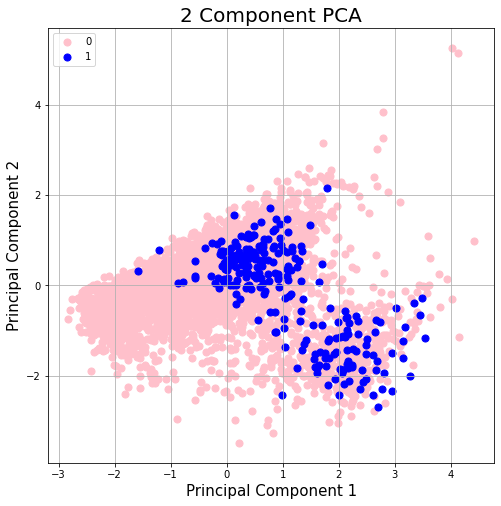

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)


targets = [0,1]
colors = ['pink', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['stroke'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()
plt.show()

A continuacion se observa una representacion de los tres componentes principales en los que se presenta el 100% de la varianza de la información.

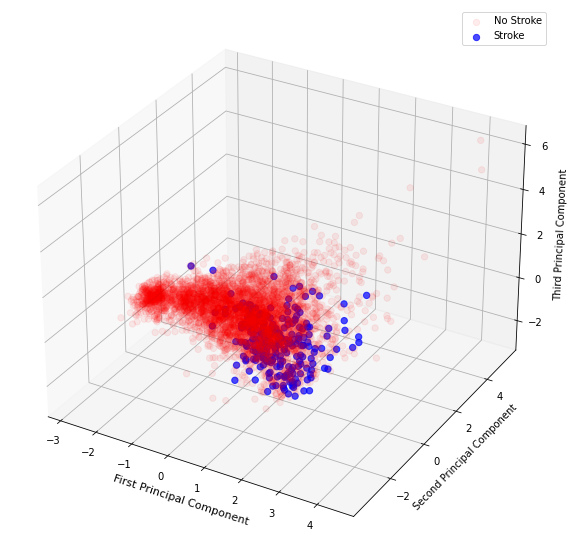

In [ ]:
Xax = principalComponents[:,0]
Yax = principalComponents[:,1]
Zax = principalComponents[:,2]
t = finalDf['stroke']

cdict = {0:'r',1:'b'}
labl = {0:'No Stroke',1:'Stroke'}
marker = {0:'o',1:'o'}
alpha = {0:.07, 1:.7}

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')

fig.patch.set_facecolor('white')
for l in np.unique(t):
 ix = np.where(t==l)
 ax.scatter(Xax[ix], Yax[ix], Zax[ix], c=cdict[l], s=40,
           label=labl[l], marker=marker[l], alpha=alpha[l])
# for loop ends
ax.set_xlabel("First Principal Component", fontsize=11)
ax.set_ylabel("Second Principal Component", fontsize=10)
ax.set_zlabel("Third Principal Component", fontsize=10)

ax.legend()
plt.show()

### Referencias PCA

R, J. A. R. (2020, diciembre). PCA con Python. Cienciadedatos.net. Recuperado 12 de noviembre de 2021, de https://www.cienciadedatos.net/documentos/py19-pca-python.html

Galarnyk, M. (2021, 4 febrero). PCA using Python (scikit-learn) - Towards Data Science. Medium. Recuperado 12 de noviembre de 2021, de https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

### K-means
El algoritmo **K-means** tiene una complejidad de orden $O(n)$, esto significa que el algoritmo escala linealmente con $n$.

*Google, D. (n.d.). What is Clustering?  |  Clustering in Machine Learning. Retrieved November 9, 2021, from https://developers.google.com/machine-learning/clustering/overview*

#### Centroid-based Clustering
Con el fin seleccionar variables con poca relación, se utiliza el **coeficiente de Correlación de Pearson (R)**, se seleccionan aquellos que tengan un valor menor a r = 0.75, considerado bajo por diversos autores.

*Devore, J. L. (2011). Probability and Statistics for Engineering and the Sciences. Cengage learning.*

In [ ]:
stroke_df.info() # Obtener una vista general de las propiedades de las variables.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   int64  
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                5110 non-null   object 
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
 12  bmi_final          5110 non-null   float64
dtypes: float64(2), int64(5), object(6)
memory usage: 519.1+ KB


A pesar de tener 6 variables númericas.  **Id, hypertension, heart_disease y stroke** son variables **boolenas** por lo que se analizan las restantes: **age, avg_glucose_level y bmi_final**. 

In [ ]:
cluster_df = stroke_df.select_dtypes(include=['int64','float64']).copy() # Seleccionamos solo las varibales numéricas.
cluster_df = cluster_df.drop(labels=['id', 'stroke','hypertension', 'heart_disease'], axis=1) # Filtramos las variables booleanas.

In [ ]:
corr = cluster_df.corr() # Coeficiente de Pearson
corr[corr.isnull() == False] # Visualizar

,age,avg_glucose_level,bmi_final
age,1.000000,0.238060,0.326271
avg_glucose_level,0.238060,1.000000,0.168751
bmi_final,0.326271,0.168751,1.000000


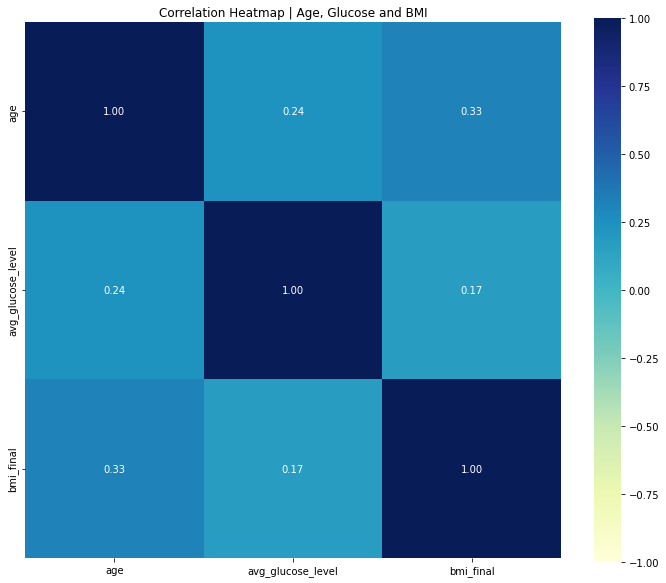

In [ ]:
plt.figure(figsize=(12,10))
sns.heatmap(data=corr, vmin=-1, vmax=1, cmap = 'YlGnBu', fmt='.2f', annot = True, square = True).set(title='Correlation Heatmap | Age, Glucose and BMI')
plt.show()

Como la data tiene diferentes rangos, se estandariza la data. Lo cual consiste es escalar los valores para que se encuentren entre un valor mínimo y máximo determinado, a menudo entre cero y uno, o para que el valor absoluto máximo de cada característica se escale a la unidad de tamaño. Esto puede lograrse utilizando **MinMaxScaler** o **MaxAbsScaler**, respectivamente.

In [ ]:
x = cluster_df.values # Seleccionamos la data de cluster_df.
min_max_scaler = preprocessing.MinMaxScaler() # Función para escalar de 0 a 1.
x_scaled = min_max_scaler.fit_transform(x) # Ajustamos la data al escale.
cluster_df_scaled = pd.DataFrame(x_scaled) # Convertimos a dataframe.

- Seleccionamos las variables **age** y **avg_glucose_level** para un ajuste.
- Seleccionamos las variables **bmi_final** y **avg_glucose_level** para un ajuste.


In [ ]:
age_avglucose_df = cluster_df_scaled.iloc[:, [0, 1]].values # Seleccionamos las columnas 'age' y 'avg_glucose_level'.
bmi_avglucose_df = cluster_df_scaled.iloc[:, [1, 2]].values # Seleccionamos las columnas 'bmi' y 'avg_glucose_level'.


El análisis de **K-means** se debe de realizar sobre variables que presenten poca correlación, como podemos ver en el grafico de arriba las tres variables presentan bajos valores en la **r** de **Pearson**, por lo que procedemos a implementar el algoritmo.

#### El método del codo
El método del codo ejecuta la agrupación de k-means en el conjunto de datos para un rango de valores de k (por ejemplo, de 1 a 10) y luego, para cada valor de k, calcula una puntuación media para todos los clusters. 

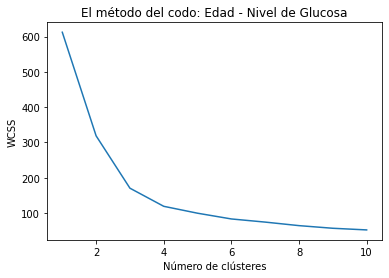

In [ ]:
# Encontrando el número óptimo de clústeres utilizando el método del codo 
from sklearn.cluster import KMeans

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(age_avglucose_df)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('El método del codo: Edad - Nivel de Glucosa')
plt.xlabel('Número de clústeres')
plt.ylabel('WCSS')
plt.show()

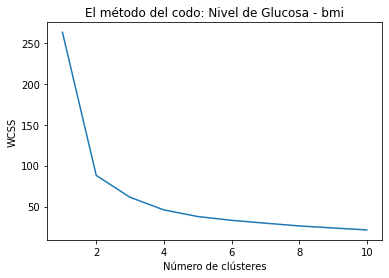

In [ ]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(bmi_avglucose_df)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('El método del codo: Nivel de Glucosa - bmi')
plt.xlabel('Número de clústeres')
plt.ylabel('WCSS')
plt.show()

### Entrenando K-means

In [ ]:
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(age_avglucose_df)

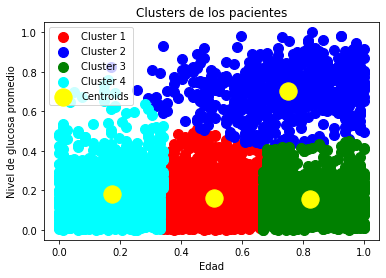

In [ ]:
plt.scatter(age_avglucose_df[y_kmeans == 0, 0], age_avglucose_df[y_kmeans == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(age_avglucose_df[y_kmeans == 1, 0], age_avglucose_df[y_kmeans == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(age_avglucose_df[y_kmeans == 2, 0], age_avglucose_df[y_kmeans == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
plt.scatter(age_avglucose_df[y_kmeans == 3, 0], age_avglucose_df[y_kmeans == 3, 1], s = 100, c = 'cyan', label = 'Cluster 4')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Centroids')
plt.title('Clusters de los pacientes')
plt.xlabel('Edad')
plt.ylabel('Nivel de glucosa promedio')
plt.legend()
plt.show()

In [ ]:
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(bmi_avglucose_df)

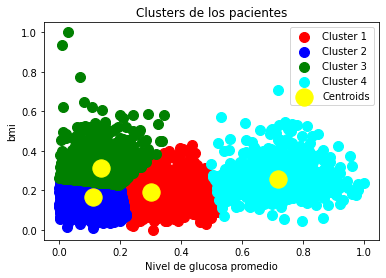

In [ ]:
plt.scatter(bmi_avglucose_df[y_kmeans == 0, 0], bmi_avglucose_df[y_kmeans == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(bmi_avglucose_df[y_kmeans == 1, 0], bmi_avglucose_df[y_kmeans == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(bmi_avglucose_df[y_kmeans == 2, 0], bmi_avglucose_df[y_kmeans == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
plt.scatter(bmi_avglucose_df[y_kmeans == 3, 0], bmi_avglucose_df[y_kmeans == 3, 1], s = 100, c = 'cyan', label = 'Cluster 4')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Centroids')
plt.title('Clusters de los pacientes')
plt.xlabel('Nivel de glucosa promedio')
plt.ylabel('bmi')
plt.legend()
plt.show()

Como podemos observar el análisis de **k-means** nos arroja grupos bien diferenciados para ambos casos. Esto nos indica que la población presenta grupos representativos en cuanto a la edad y su nivel de glucosa promedio, asimismo, vemos la misma relación, aunque en menor medida, para la relación entre el índice de masa de corporal (bmi). Es importante destacar que el número de clusteres idóneo es de 4, ya que, de usar mayor o menor número tendriamos una convergencia menor y grupos menos diferenciados.

# Binary logistic regression 

El modelo binary logistic regression, es una regresión lineal que busca predecir los valores de una variable dependiente binaria, es decir puede ser 0 o 1, yes or no. Entonces nuestra variable a predecir es si existe un stroke o no, este modelo se puede aplicar debido a que tenemos una variable a predecir de tipo binaria.


Este modelo puede aceptar variables independientes continuas y categoricas, para el caso de la edad se realizara una transformación a categoricos, es decir, se tomaran intervalos de edad para simplificar la interpretación de datos.

In [66]:
# AGE
age_reg = pd.cut(LogReg_df['age'], bins = 10, labels = list(range(1,11)))
LogReg_df['age'] = age_reg
LogReg_df['age'] = LogReg_df['age'].astype('int64')
LogReg_df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,bmi_final
0,9046,Male,9,0,1,Yes,Private,Urban,228.690002,36.6,formerly smoked,1,36.600000
1,51676,Female,8,0,0,Yes,Self-employed,Rural,202.210007,N/A,never smoked,1,28.893237
2,31112,Male,10,0,1,Yes,Private,Rural,105.919998,32.5,never smoked,1,32.500000
3,60182,Female,6,0,0,Yes,Private,Urban,171.229996,34.4,smokes,1,34.400000
4,1665,Female,10,1,0,Yes,Self-employed,Rural,174.119995,24,never smoked,1,24.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,10,1,0,Yes,Private,Urban,83.750000,N/A,never smoked,0,28.893237
5106,44873,Female,10,0,0,Yes,Self-employed,Urban,125.199997,40,never smoked,0,40.000000
5107,19723,Female,5,0,0,Yes,Self-employed,Rural,82.989998,30.6,never smoked,0,30.600000
5108,37544,Male,7,0,0,Yes,Private,Rural,166.289993,25.6,formerly smoked,0,25.600000


Una vez con los datos de edad ya categorizados, se realizara un mapeado de datos para convertir los string categoricos a enteros categoricos ya que por propositos del modelo debemos alimentarlo con unicamente valores númericos, para esto se realizaron diccionarios para no perder información al realizar el mapeado.

In [67]:
# Mapeado
# Se convierten los datos a string
LogReg_df['gender'] = LogReg_df['gender'].astype(str)
LogReg_df['ever_married'] = LogReg_df['ever_married'].astype(str)
LogReg_df['work_type'] = LogReg_df['work_type'].astype(str)
LogReg_df['Residence_type'] = LogReg_df['Residence_type'].astype(str)
LogReg_df['smoking_status'] = LogReg_df['smoking_status'].astype(str)

# Se crean diccionarios con llaves y valores
dict_gender = {'Male': 0, 'Female': 1, 'Other': 2}
dict_work = {'Private': 0, 'Self-employed': 1, 'children': 2, 'Govt_job': 3, 'Never_worked': 4}
dict_residence = {'Rural': 0, 'Urban': 1}
dict_smoking = {'never smoked': 0, 'Unknown': 1, 'formerly smoked': 2, 'smokes': 3}

# Se realiza el mapeado con los diccionarios
LogReg_df['gender'] = LogReg_df['gender'].map(dict_gender)

LogReg_df['ever_married'] = pd.Series(np.where(LogReg_df.ever_married.values == 'Yes', 1, 0),
          LogReg_df.index)

LogReg_df['work_type'] = LogReg_df['work_type'].map(dict_work)

LogReg_df['Residence_type'] = LogReg_df['Residence_type'].map(dict_residence)

LogReg_df['smoking_status'] = LogReg_df['smoking_status'].map(dict_smoking)

In [68]:
LogReg_df #Visualización del dataframe con los datos preparados

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,bmi_final
0,9046,0,9,0,1,1,0,1,228.690002,36.6,2,1,36.600000
1,51676,1,8,0,0,1,1,0,202.210007,N/A,0,1,28.893237
2,31112,0,10,0,1,1,0,0,105.919998,32.5,0,1,32.500000
3,60182,1,6,0,0,1,0,1,171.229996,34.4,3,1,34.400000
4,1665,1,10,1,0,1,1,0,174.119995,24,0,1,24.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,1,10,1,0,1,0,1,83.750000,N/A,0,0,28.893237
5106,44873,1,10,0,0,1,1,1,125.199997,40,0,0,40.000000
5107,19723,1,5,0,0,1,1,0,82.989998,30.6,0,0,30.600000
5108,37544,0,7,0,0,1,0,0,166.289993,25.6,2,0,25.600000


Con propositos de mejorar la estabilidad de la convergencia del modelo, se realiza un escalado de los datos continuos de manera uniforme de 0 a 1.

In [69]:
x = LogReg_df[['avg_glucose_level', 'bmi_final']] # Seleccionamos la data de LogReg_df.
min_max_scaler = preprocessing.MinMaxScaler() # Función para escalar de 0 a 1.
x_scaled = min_max_scaler.fit_transform(x) # Ajustamos la data al escale
cluster_df_scaled = pd.DataFrame(x_scaled) # Convertimos a dataframe
cluster_df_scaled = cluster_df_scaled.astype('float64') # Convierte a float
cluster_df_scaled.reset_index(drop=True, inplace=True) # Se resetean los indices
LogReg_df.reset_index(drop=True, inplace=True) 

LogReg_df[['avg_glucose_level', 'bmi']] = cluster_df_scaled
LogReg_df # Se visualiza el Dataframe ya escalado

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,bmi_final
0,9046,0,9,0,1,1,0,1,0.801265,0.301260,2,1,36.600000
1,51676,1,8,0,0,1,1,0,0.679023,0.212981,0,1,28.893237
2,31112,0,10,0,1,1,0,0,0.234512,0.254296,0,1,32.500000
3,60182,1,6,0,0,1,0,1,0.536008,0.276060,3,1,34.400000
4,1665,1,10,1,0,1,1,0,0.549349,0.156930,0,1,24.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,1,10,1,0,1,0,1,0.132167,0.212981,0,0,28.893237
5106,44873,1,10,0,0,1,1,1,0.323516,0.340206,0,0,40.000000
5107,19723,1,5,0,0,1,1,0,0.128658,0.232532,0,0,30.600000
5108,37544,0,7,0,0,1,0,0,0.513203,0.175258,2,0,25.600000


In [70]:
LogReg_df['age'] = LogReg_df['age'].astype('int64')
#LogReg_df['stroke'] = LogReg_df['stroke'].astype('category')
LogReg_df.dtypes

id                     int64
gender                 int64
age                    int64
hypertension           int64
heart_disease          int64
ever_married           int64
work_type              int64
Residence_type         int64
avg_glucose_level    float64
bmi                  float64
smoking_status         int64
stroke                 int64
bmi_final            float64
dtype: object

### Entrenamiento del modelo
Se realizara el modelo con la función smf.logit, entonces, este modelo es una regresión lineal con relación a un logaritmo.
$log(\frac{p}{1-p}) = b_0 + b_1 x_1 + b_2 x_2 + b_3 x_3 + ...$, entonces nuestro modelo busca encontrar los pesos correspondientes a cada variable independiente para aproximar nuestro logaritmo, en este caso la probabilidad de obtener un stroke.

In [71]:
riskmodel = smf.logit(formula = 'stroke ~ age + hypertension + heart_disease + ever_married + work_type + Residence_type + avg_glucose_level + bmi + smoking_status', data = LogReg_df).fit(method = 'powell') 
riskmodel.summary()

Optimization terminated successfully.
         Current function value: 0.155299
         Iterations: 19
         Function evaluations: 2124


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 stroke   No. Observations:                 5110
Model:                          Logit   Df Residuals:                     5100
Method:                           MLE   Df Model:                            9
Date:                Fri, 12 Nov 2021   Pseudo R-squ.:                  0.2026
Time:                        18:48:27   Log-Likelihood:                -793.58
converged:                       True   LL-Null:                       -995.19
Covariance Type:            nonrobust   LLR p-value:                 2.816e-81
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -7.6389      0.480    -15.905      0.000      -8.580      -6.698
age                   0.5880      0.045     13.163      0.000       0.500       0.676
hypertension          0.4103      0.163      2.516      0.012       0.091       0.730
heart_disease         0.3026      0.190      1.596      0.111      -0.069       0.674
ever_married         -0.1975      0.222     -0.891      0.373      -0.632       0.237
work_type            -0.0702      0.069     -1.010      0.312      -0.206       0.066
Residence_type        0.0613      0.138      0.444      0.657      -0.209       0.332
avg_glucose_level     0.9101      0.258      3.526      0.000       0.404       1.416
bmi                  -0.0612      0.979     -0.063      0.950      -1.980       1.858
smoking_status        0.0946      0.062      1.532      0.125      -0.026       0.216
=====================================================================================
"""

Observando los resultados, podemos fijarnos en la columna P>|z|, este valor nos representa el p-value y para las variables que su valor sea menor a 0.05 se toman como variables independientes significativas para que ocurra o no un stroke.<br>
Por lo que a partir del primer modelo, que fue alimentado por todas las variables, así que tomando en consideración lo anterior mencionado, podemos descartar variables que no toman relevancia para determinar si tendra un stroke o no.

Las variables independientes relevantes seleccionados son age, hypertension, avg_glucose_level y por cuestiones del equipo decidimos personalmente incluir heart_disease como una variable relevante más.

Entonces, realizamos de nuevo el modelo con estas variables unicamente.

In [72]:
# Training
riskmodel = smf.logit(formula = 'stroke ~ hypertension + heart_disease + avg_glucose_level + age', data = LogReg_df).fit(method = 'powell')
riskmodel.summary()

Optimization terminated successfully.
         Current function value: 0.155797
         Iterations: 9
         Function evaluations: 533


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 stroke   No. Observations:                 5110
Model:                          Logit   Df Residuals:                     5105
Method:                           MLE   Df Model:                            4
Date:                Fri, 12 Nov 2021   Pseudo R-squ.:                  0.2000
Time:                        18:49:10   Log-Likelihood:                -796.12
converged:                       True   LL-Null:                       -995.19
Covariance Type:            nonrobust   LLR p-value:                 7.064e-85
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -7.5194      0.364    -20.633      0.000      -8.234      -6.805
hypertension          0.3718      0.162      2.291      0.022       0.054       0.690
heart_disease         0.3682      0.186      1.977      0.048       0.003       0.733
avg_glucose_level     0.8636      0.251      3.443      0.001       0.372       1.355
age                   0.5667      0.043     13.300      0.000       0.483       0.650
=====================================================================================
"""

Se observa que el p-value se mantiene por debajo de 0.05 de nuevo para todas las variables, por lo que ahora sí podemos utilizar los coeficientes dados por el modelo.

Podemos observar que la variable que más impacto tienen a la determinación de strokes es el promedio del nivel de la glucosa y la edad, ya que sus coeficientes son mayores.

In [ ]:
Obtenemos los intervalos de confianza para nuestras variables con el metodo conf_int

In [73]:
conf = riskmodel.conf_int()
conf['OR'] = riskmodel.params
conf.columns = ['2.5%', '97.5%', 'OR']
print(np.exp(conf))

                       2.5%     97.5%        OR
Intercept          0.000266  0.001108  0.000542
hypertension       1.055178  1.993403  1.450308
heart_disease      1.003094  2.082035  1.445156
avg_glucose_level  1.450618  3.877779  2.371745
age                1.621214  1.915926  1.762421


### Predicciones
Una vez entrenado el modelo, podemos realizar predicciones con el para esto utilizamos el metodo predict, se realizo una tabla de clasificación para visualizar nuestros resultados.

In [74]:
predicted_values1 = riskmodel.predict()
threshold=0.054685
predicted_class1=np.zeros(predicted_values1.shape)
predicted_class1[predicted_values1>threshold]=1
cm1 = confusion_matrix(LogReg_df['stroke'],predicted_class1)
print('Confusion Matrix : \n', cm1)

Confusion Matrix : 
 [[3673 1188]
 [  51  198]]


La tabla muestra que nuestro modelo predijo 3673 como no strokes y 198 como strokes, con 1188 como predicciones incorrectas como strokes y 51 predicciones incorrectas como no strokes

Como nuestra data estaba mal balanceada al tener más casos de uno que de otro, tuvimos que realizar un ajuste con el threshold con la función roc_curve. Así obtuvimos el mejor threshold para nuestra predicción.

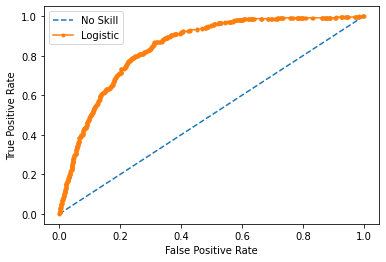

Best Threshold=0.054685, G-Mean=0.775


In [77]:
from sklearn.metrics import roc_curve
from numpy import sqrt, argmax

y = riskmodel.predict(LogReg_df[['hypertension', 'heart_disease', 'avg_glucose_level', 'age']])
y = y.rename("predict")
query1 = """SELECT predict
       FROM y
    WHERE predict >= 0.054685 """

query = """SELECT CASE WHEN predict >= 0.054685 Then 1
                       ELSE 0
                  END as predic
       FROM y
       ORDER BY predic DESC"""
new = pysqldf(query)
new

fpr, tpr, thresholds = roc_curve(LogReg_df['stroke'], y)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

gmeans = sqrt(tpr * (1-fpr))
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Por ultimo solamente se realizo grafico mostrando los casos donde se obtiene un stroke o un no stroke, para diversos valores de las variables independientes.

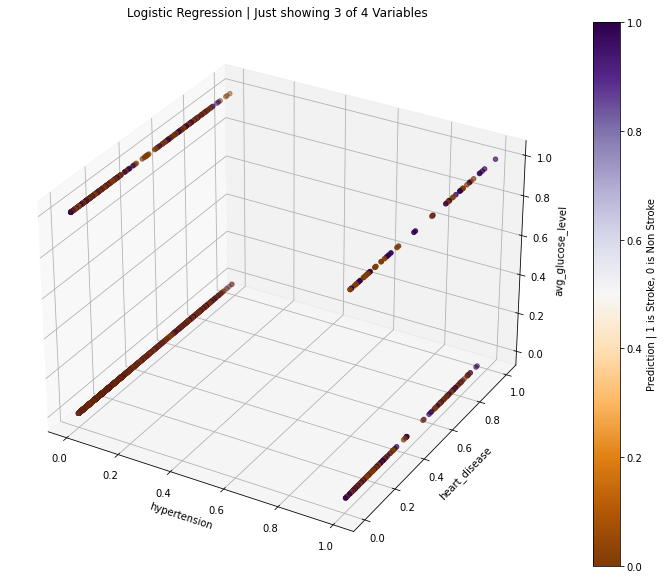

In [80]:
# 4D Visualization, using color as 4th Dimension
import matplotlib.pyplot as plt
z = LogReg_df[['hypertension']]
x = LogReg_df[['heart_disease']]
y = LogReg_df[['avg_glucose_level']]
c = new['predic'].astype('category') 

fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(111, projection='3d')
ax.title.set_text('Logistic Regression | Just showing 3 of 4 Variables ')
ax.set_xlabel('hypertension')
ax.set_ylabel('heart_disease')
ax.set_zlabel('avg_glucose_level')

img = ax.scatter(x, y, z, c=c, cmap='PuOr')
cbar = plt.colorbar(img)
cbar.set_label('Prediction | 1 is Stroke, 0 is Non Stroke')
plt.show()


# Binary Decision Tree

Gracias al análisis arriba este modelo se comenzó enterado de que teníamos "unbalanced data", sin embargo, no se hacen adecuaciones porque se corrió el modelo y se llegó a un buen % de precisión no se hicieron adecuaciones. ¿Por qué no? Los árboles de decisión tienen un excelente manejo cuando las clases a las que tiene que llegar tienen una diferencia pronunciada si se usa GINI

¿Qué es un decision tree es un modelo que puede cubrir clasificación y regresión, apartir de un crecimiento de nodos de decisión en cada nivel del árbol. En nuestro caso hay un nodo principal y este tendrá 2 nodos, y cada uno de los nodos tendrá otros dos hasta alcanzar 5 niveles.

         []       Level 0
        / \       
      []   []     Level 1
     / \   / \     
    [] [] [] []   Level 2
                  ...
                  Level 5
 

Prashant Gupta. (2017, May 17). Decision Trees in Machine Learning - Towards Data Science. Medium; Towards Data Science. https://towardsdatascience.com/decision-trees-in-machine-learning-641b9c4e8052

In [6]:
data = stroke_df.drop(columns =['id', 'bmi'])
X_train, X_test, y_train, y_test = train_test_split(
                                        data.drop(columns = 'stroke'),
                                        data['stroke'],
                                        random_state = 123
                                    )

cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()
numeric_cols = X_train.select_dtypes(include=['float64', 'int64']).columns.to_list()


En el bloque de arriba lo que se está haciendo es generar el train y test data set para poder ver que el modelo esté generalizando.

In [7]:
preprocessor = ColumnTransformer(
                    [('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
                    remainder='passthrough'
               )

X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

encoded_cat = preprocessor.named_transformers_['onehot'].get_feature_names(cat_cols)
labels = np.concatenate([encoded_cat,numeric_cols])

# Conversión a dataframe
X_train_prep = pd.DataFrame(X_train_prep, columns=labels)
X_test_prep  = pd.DataFrame(X_test_prep, columns=labels)
X_train_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3832 entries, 0 to 3831
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   gender_Female                   3832 non-null   float64
 1   gender_Male                     3832 non-null   float64
 2   gender_Other                    3832 non-null   float64
 3   ever_married_No                 3832 non-null   float64
 4   ever_married_Yes                3832 non-null   float64
 5   work_type_Govt_job              3832 non-null   float64
 6   work_type_Never_worked          3832 non-null   float64
 7   work_type_Private               3832 non-null   float64
 8   work_type_Self-employed         3832 non-null   float64
 9   work_type_children              3832 non-null   float64
 10  Residence_type_Rural            3832 non-null   float64
 11  Residence_type_Urban            3832 non-null   float64
 12  smoking_status_Unknown          38

Aquí usamos one hot encoder solo para las variables categoricas y recreamos con eso el train y test dataset.

Profundidad del árbol: 5
Número de nodos terminales: 31


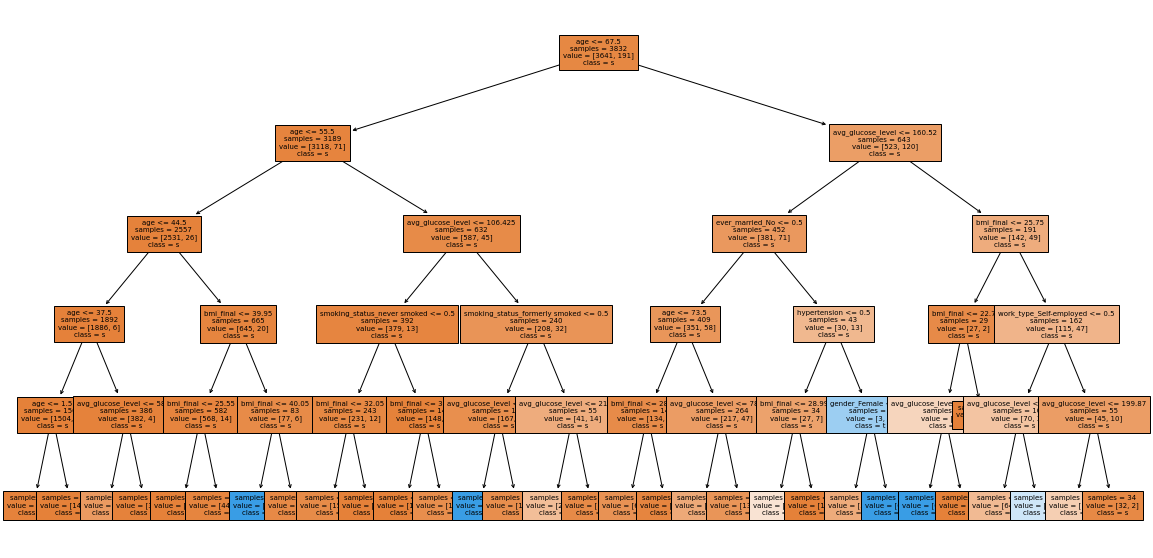

In [8]:
modelo = DecisionTreeClassifier(
            max_depth         = 5,
            criterion         = 'gini',
            random_state      = 123
          )

modelo.fit(X_train_prep, y_train)

fig, ax = plt.subplots(figsize=(20, 10))

print(f"Profundidad del árbol: {modelo.get_depth()}")
print(f"Número de nodos terminales: {modelo.get_n_leaves()}")

plot = plot_tree(
            decision_tree = modelo,
            feature_names = labels.tolist(),
            class_names   = 'stroke',
            filled        = True,
            impurity      = False,
            fontsize      = 7,
            ax            = ax
       )

En el bloque de arriba se está generando el modelo con el train dataset y se hace un plot de nuestro decision tree

In [9]:

predicciones = modelo.predict(X = X_test_prep,)

print("Matriz de confusión")
print("-------------------")
confusion_matrix(
    y_true    = y_test,
    y_pred    = predicciones
)

Matriz de confusión
-------------------


array([[1215,    5],
       [  54,    4]])

#### Esto concluyó nuestro modelo
* Verdaderos Positivos - 1215
* Verdaderos Negativos -    4
* Falsos Positivos     -    5
* Falsos Negativos     -   54

In [62]:
'''
Nuestro modelo tiene un buen porcentaje de accuracy
'''

accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )
print(f"El accuracy de test es: {100 * accuracy} %")

El accuracy de test es: 95.38341158059468 %


In [11]:
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores = pd.DataFrame(
                            {'predictor': labels.tolist(),
                             'importancia': modelo.feature_importances_}
                            )
importancia_predictores.sort_values('importancia', ascending=False)


Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
16,age,0.472180
19,avg_glucose_level,0.229064
20,bmi_final,0.139950
17,hypertension,0.040282
0,gender_Female,0.033325
13,smoking_status_formerly smoked,0.027948
3,ever_married_No,0.026727
8,work_type_Self-employed,0.026041
14,smoking_status_never smoked,0.004484
5,work_type_Govt_job,0.000000


### Cierre Decision tree

Podemos ver que las variables relevantes para la predicción son si alguien es mujer, hipertensión, bmi, promedio de glucosa y edad. Creemos que con este modelo en específico podría ser una buen predicción de sondeo.

# Etapa 4: Conclusiones

El equipo aprendió bastante de la semana si bien venimos de contextos distintos (computación, física y ciencia de datos). Adrián aprendió que apartir de una regresión logística se pueden tener resultados binarios con variables independientes continuas con una regresión logística binaria. Jesús tuvo la oportunidad de aplicar sus conocimientos de PCA para lograr visualizar los datos y no para el uso común de solo reducir la dimensionalidad de cuando se tiene más de 5 columnas, ya que aquí solo se usaron pocas variables. Ángel aprendió sobre los datos para poder realizar la clusterización y que se tiene que hacer un análisis estadístico serio para poder evitar datos sesgados en los clusters. Armando tuvo oportunidad de trabajar con unbalanced data y poder visualizar la lógica detrás de los ataques cerebrales y generar visualizaciones.

### Visualización

Se hiceron 9 visualizaciones, 8 en Tableau y una en python, todas con el objetivo de poder explorar la data de strokes y se considera que una persona que necesite entender el dataset se podría beneficiar de estas visualizaciones ya que muestran de distintas maneras la composición del dataset




### Estadística




El análisis estadístico nos brindo el primer acercamiento para entender las relaciones entre las variables del dataset. Calculando los primeros cuatro momentos centrados en la media, se puede inferir la dispersión, centralización y variación de la data. Lo anterior, fue de vital importancia para la selección de los modelos y técnica de análisis a utilizar, ya que, el dataset presenta datos numéricos y categóricos.

### PCA




El metodo de Analisis de componentes principales fue utilizado en este caso unicamente para la visualizacion de los datos y para obtener mas información sobre la varianza explicada y los componentes principales, realmente no se necesita reducir las dimensiones ya que solo manejamos 3 variables numericas. Realmente el analisis de componentes principales en este caso no es de las mejores opciones para manejar esta base de datos, en caso de que entraran mas variables de salud de cada individuo a los datos podriamos utilizar este metodo para ir descartando la importancia de cada variable utilizando la variabilidad que tiene cada una en el resultado final de los derrames cerebrales.

### K Means
Como podemos observar el análisis de **k-means** parte de calcular la correlación que existe entre variables, ya que, los grupos bien diferenciados son aquellos que presentan poca correlación, en este caso el coeficiente de pearson. Una vez obtenido el número idóneo de clústeres, procedimos a clasificar los datos. En ambos casos, los resultados obtenidos son grupos (clústeres) bien diferenciados. Esto nos indica que la población se puede subdivir en grupos, con características muy representativos, para este caso la edad, el nivel de glucosa promedio y el índicie de masa corporal.
Después de realizar este análisis, los pasos futuros serían desarrollar modelos de clasficación que puedan tomar en cuenta los datos categóricos o booleanos, en orden de establecer una mejor división de los datos. Finalmente, cabe mencionar que el análisis de **k-medias** nos exige realizar un correcto muestreo para evitar tener data sesgada que genere errores o problemas de convergencia en futuros algoritmos como redes neuronales profundas. 


### Logistic Regression



Como podemos visualizar en el análisis de **Logistic regression**, se pudo observar que existen 4 variables que impactan significativamente la ocurrencia de un stroke o no, a partir del modelo pudimos realizar una regresión lineal para predecir ocurrencias, este modelo funciona debido a que la variable dependiente (stroke) es binaria, únicamente puede tomar 2 valores.<br>
Se obtuvieron buenas predicciones sin embargo no se obtuvo una regresión perfecta debido a que no se ajusta la curva a partir del modelo, esto podría deberse a como fueron introducidos los datos o la correlación entre estos. Posiblemente se podria obtener mejores resultados si se tratara la data de una mejor manera para el modelo, y si las variables independientes tuvieran una correlación entre ellas mayores R_pearson > 0.75.

### Binary Tree
Del binary tree podemos concluir que es un buen modelo que representa bien la situación de clasificación de ataques cerebrales y en etapas a futuro sería encontrar la mejor profundidad del árbol con pruning o para considerar mejor la data unbalanced un random forest con weighted gin, pero en el plazo de esta semana los resultados son aceptables y dejaron buena oportunidad de trabajar con datos y aprender. Lo padre del decision tree es que como no es modelo de caja negra, cualquier persona que esté usando nuestro modelo podría ver que patrón se usó para llegar a su resultado. 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=99305eef-5540-4cbc-9d07-c0395c2ada54' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>